In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Load datasets
df_city_hour = pd.read_csv('/content/city_hour.csv')
df_station_hour = pd.read_csv('/content/station_hour.csv')
df_station_day = pd.read_csv('/content/station_day.csv')
df_stations = pd.read_csv('/content/stations.csv')

# Display initial rows
print(df_station_day.head())
print(df_stations.head())
print(df_city_hour.head())
print(df_station_hour.head())


<ipython-input-2-28acb68306cb>:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_station_hour = pd.read_csv('/content/station_hour.csv')


  StationId        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0     AP001  2017-11-24  71.36  115.75  1.75  20.65  12.40  12.19  0.10   
1     AP001  2017-11-25  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
2     AP001  2017-11-26  78.32  129.06  1.26  26.00  14.85  10.28  0.14   
3     AP001  2017-11-27  88.76  135.32  6.60  30.85  21.77  12.91  0.11   
4     AP001  2017-11-28  64.18  104.09  2.56  28.07  17.01  11.42  0.09   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
0  10.76  109.26     0.17     5.92    0.10    NaN        NaN  
1  15.24  127.09     0.20     6.50    0.06  184.0   Moderate  
2  26.96  117.44     0.22     7.95    0.08  197.0   Moderate  
3  33.59  111.81     0.29     7.63    0.12  198.0   Moderate  
4  19.00  138.18     0.17     5.02    0.07  188.0   Moderate  
  StationId                                     StationName  \
0     AP001                  Secretariat, Amaravati - APPCB   
1     AP002  Anand Kala Kshetram, Rajamahendr

In [3]:
# Make a copy of the station_day dataset
df = df_station_day.copy()
print("Initial shape:", df.shape)

# Drop rows with missing AQI
df.dropna(subset=['AQI'], inplace=True)

# Fill missing values with column means
df.fillna(df.mean(numeric_only=True), inplace=True)

# Features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
            'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
X = df[features]
y = df['AQI']


Initial shape: (108035, 16)


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train, y_train)

# Predict
y_pred = reg_model.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 0.9191417870701715
RMSE: 37.361482918583874


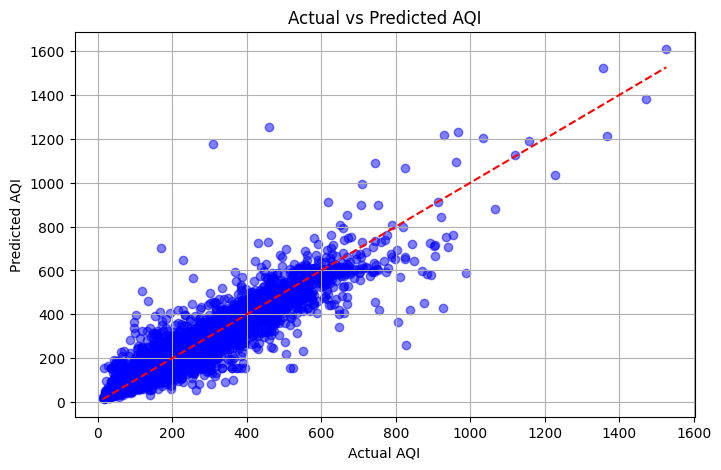

In [5]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.grid(True)
plt.show()


In [6]:
# Select features and drop NA
df_cls = df_station_day[['PM2.5', 'NO2', 'Toluene', 'AQI']].dropna()

# Categorize AQI into levels
def aqi_category(aqi):
    if aqi <= 100:
        return 'low'
    elif aqi <= 200:
        return 'medium'
    else:
        return 'high'

df_cls['quality_level'] = df_cls['AQI'].apply(aqi_category)

# Encode category
le = LabelEncoder()
df_cls['quality_level_encoded'] = le.fit_transform(df_cls['quality_level'])

# Feature selection
X_cls = df_cls[['PM2.5', 'NO2', 'Toluene']]
y_cls = df_cls['quality_level_encoded']


In [7]:
# Normalize features
scaler = StandardScaler()
X_cls_scaled = scaler.fit_transform(X_cls)

# Split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls_scaled, y_cls, test_size=0.2, random_state=42)

# Train classifier
cls_model = RandomForestClassifier(random_state=42)
cls_model.fit(X_train_cls, y_train_cls)

# Predict
y_pred_cls = cls_model.predict(X_test_cls)


In [8]:
# Evaluation metrics
accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls, average='macro')
recall = recall_score(y_test_cls, y_pred_cls, average='macro')
report = classification_report(y_test_cls, y_pred_cls, target_names=le.classes_)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n", report)


Accuracy: 0.7723768018773047
Precision: 0.7752946003175999
Recall: 0.7727621585685811

Classification Report:
               precision    recall  f1-score   support

        high       0.91      0.83      0.87      4143
         low       0.74      0.81      0.78      3763
      medium       0.68      0.68      0.68      4026

    accuracy                           0.77     11932
   macro avg       0.78      0.77      0.77     11932
weighted avg       0.78      0.77      0.77     11932



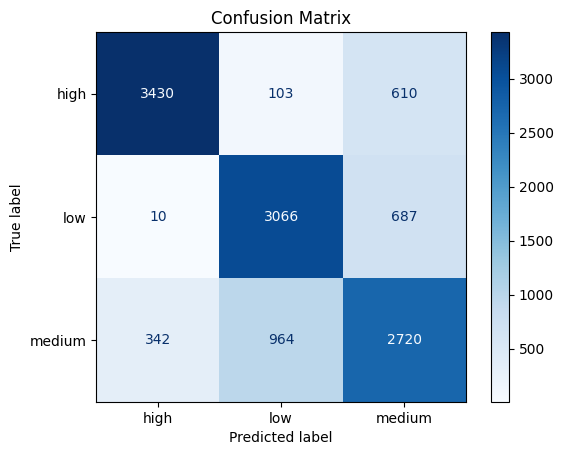

In [9]:
cm = confusion_matrix(y_test_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


<ipython-input-10-047052153496>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_aqi.index, y=city_aqi.values, palette='viridis')


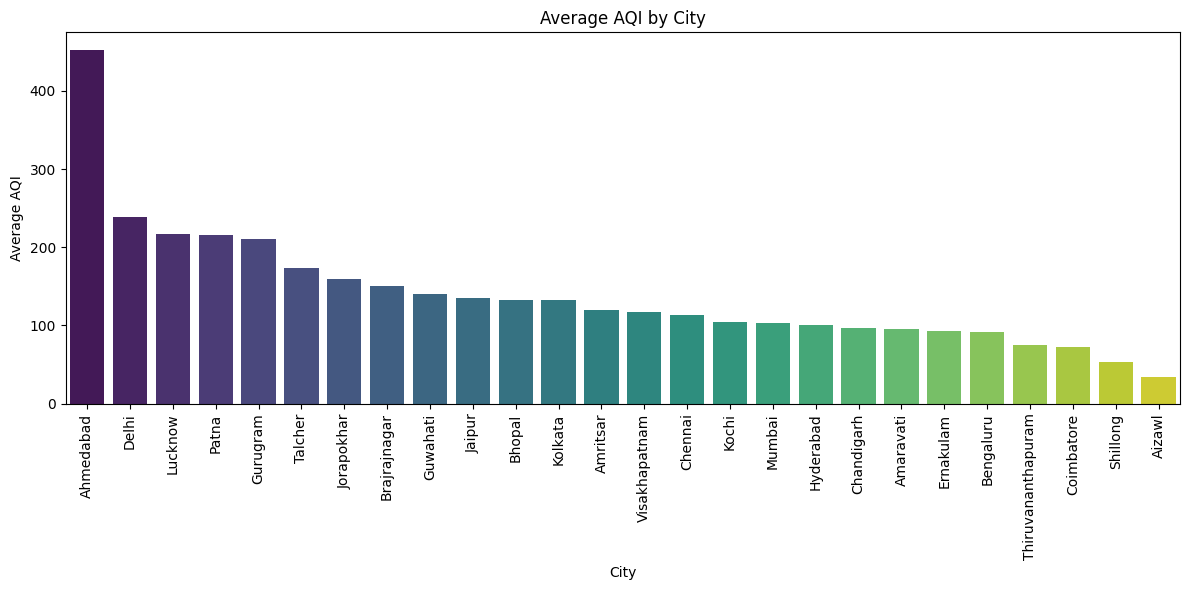

In [10]:
df = pd.merge(df, df_stations[['StationId', 'City']], on='StationId', how='left')


city_aqi = df.groupby('City')['AQI'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=city_aqi.index, y=city_aqi.values, palette='viridis')
plt.xticks(rotation=90)
plt.ylabel('Average AQI')
plt.title('Average AQI by City')
plt.tight_layout()
plt.show()